In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from google.colab import files


In [ ]:
df = pd.read_csv('/content/indian movies.csv')
df.head()

,ID,Movie Name,Year,Timing(min),Rating(10),Votes,Genre,Language
0,tt0398974,Dr. Shaitan,1960,-,-,-,-,hindi
1,tt1702558,Nadir Khan,1968,-,-,-,-,urdu
2,tt0493437,Apna Sapna Money Money,2006,134 min,5.3,"1,892","Comedy, Musical, Romance",hindi
3,tt0273405,Aag Aur Sholay,1987,-,2.2,20,-,urdu
4,tt0049595,Parivar,1956,-,7.4,21,"Comedy, Drama, Family",hindi


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50602 entries, 0 to 50601
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50602 non-null  object
 1   Movie Name   50602 non-null  object
 2   Year         49041 non-null  object
 3   Timing(min)  50602 non-null  object
 4   Rating(10)   50602 non-null  object
 5   Votes        50602 non-null  object
 6   Genre        50602 non-null  object
 7   Language     50602 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [ ]:
df.describe()

,ID,Movie Name,Year,Timing(min),Rating(10),Votes,Genre,Language
count,50602,50602,49041,50602,50602,50602,50602,50602
unique,46106,42442,579,259,92,2951,718,19
top,-,Alif Laila,2018,-,-,-,Drama,hindi
freq,2508,167,1934,25892,26926,26925,13529,14350


In [ ]:

#Handle missing values in the 'Year' column
df = df.dropna(subset=['Year'])

In [ ]:

#Ensure data types are consistent for 'Year'
df['Year'] = df['Year'].astype(str)


<ipython-input-6-b6a541652e80>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(str)


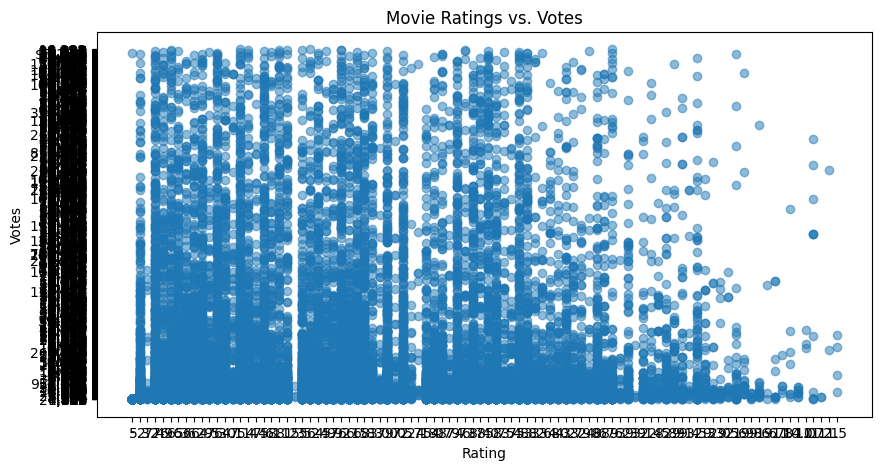

In [ ]:
import matplotlib.pyplot as plt

#Create a scatter plot of the movie ratings and votes
plt.figure(figsize=(10, 5))
plt.scatter(df['Rating(10)'], df['Votes'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Votes')
plt.title('Movie Ratings vs. Votes')
plt.show()


In [ ]:
#Clean and convert the 'Rating(10)' column
#Replace invalid entries with NaN, then drop them
df['Rating(10)'] = pd.to_numeric(df['Rating(10)'], errors='coerce')
df = df.dropna(subset=['Rating(10)'])

In [ ]:
# Clean and convert the 'Votes' column
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df = df.dropna(subset=['Votes'])

<ipython-input-9-47c69f290b84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')


In [ ]:
#Check for null values in other columns and drop them if any
df = df.dropna(subset=['Movie Name', 'Genre', 'Language'])

In [ ]:
#Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [ ]:
#Combine 'Genre' and 'Language' into a single string
df['combined_features'] = df['Genre'] + ' ' + df['Language']

data preprocessing

In [ ]:
#Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
#Compute the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [ ]:
#Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#Construct a reverse map of indices and movie names
indices = pd.Series(df.index, index=df['Movie Name']).drop_duplicates()

In [ ]:
##modelling
#Define a function to get movie recommendations
def get_recommendations(title, similarity_matrix):
    #get the index of the movie that matches the title
    idx = df[df['Movie Name'] == title].index[0]

    #get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(similarity_matrix[idx]))

    #sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #get the scores of the 5 most similar movies
    sim_scores = sim_scores[1:6]

    #get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    #return the top 5 most similar movies
    return df['Movie Name'].iloc[movie_indices].tolist()

#Test the recommendation system
print(get_recommendations('Parivar', similarity_matrix))



['Safed Jhoot', 'Kaun Kitney Paani Mein', 'Sagina', 'Nanhe Jaisalmer: A Dream Come True', 'Daayen Ya Baayen']


data evaluation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

#Extract features from the Genre and Language columns
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df['Genre'] + ' ' + df['Language'])

#Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(features)

#Define a function to evaluate the model
def evaluate_model(title, similarity_matrix):
    #Get the top 10 recommended movies
    recommendations = get_recommendations(title, similarity_matrix)

    #Get the actual genres and languages of the recommended movies
    actual = df[df['Movie Name'].isin(recommendations)][['Genre', 'Language']]

    #Get the predicted genres and languages of the recommended movies
    predicted = df[df['Movie Name'] == title][['Genre', 'Language']].values

    #Compute the precision, recall, and F1 score for genres
    precision_genre = precision_score(actual['Genre'], predicted[0], average='weighted')
    recall_genre = recall_score(actual['Genre'], predicted[0], average='weighted')
    f1_genre = f1_score(actual['Genre'], predicted[0], average='weighted')

    #Compute the precision, recall, and F1 score for languages
    precision_language = precision_score(actual['Language'], predicted[1], average='weighted')
    recall_language = recall_score(actual['Language'], predicted[1], average='weighted')
    f1_language = f1_score(actual['Language'], predicted[1], average='weighted')

    #Return the precision, recall, and F1 score for genres and languages
    return precision_genre, recall_genre, f1_genre, precision_language, recall_language, f1_language

#Test the function
precision_genre, recall_genre, f1_genre, precision_language, recall_language, f1_language = evaluate_model('Parivar', similarity_matrix)
print('Precision (genre):', precision_genre)
print('Recall (genre):', recall_genre)
print('F1 score (genre):', f1_genre)
print('Precision (language):', precision_language)
print('Recall (language):', recall_language)
print('F1 score (language):', f1_language)


Similarity scores for 'Parivar': [(0, array([0.        , 1.        , 0.51856289, ..., 0.12545299, 0.        ,
       0.25112435])), (1, array([0.        , 0.7181056 , 0.72212623, ..., 0.17469992, 0.        ,
       0.34970393]))]
Sorted similarity scores for 'Parivar': [(0, array([0.        , 1.        , 0.51856289, ..., 0.12545299, 0.        ,
       0.25112435])), (1, array([0.        , 0.7181056 , 0.72212623, ..., 0.17469992, 0.        ,
       0.34970393]))]
Top 10 similarity scores for 'Parivar': [(1, array([0.        , 0.7181056 , 0.72212623, ..., 0.17469992, 0.        ,
       0.34970393]))]
Precision (genre): 0.5
Recall (genre): 0.5
F1 score (genre): 0.5
Precision (language): 1.0
Recall (language): 0.5
F1 score (language): 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
